In [1]:
### Import the necessary libraries ###
import os
import cv2
import pickle
import numpy as np
import face_recognition as fr

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import backend as K

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
### Define the two models and their respective vector preprocessing method ###

''' Define Facenet '''
def get_facenet_model():
    emb_shape = 512
    w_decay = 1e-4
    num_classes = 5000

    # loading facenet
    #model_face = load_model('models/facenet_keras.h5')
    model_face = tf.keras.applications.InceptionV3(include_top=False, input_shape=(170,170,3))

    # freeze all Facenet layers
    for layer in model_face.layers[:]:
        layer.trainable = False

    last = model_face.output
    x = Flatten()(last)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(emb_shape, activation='relu', kernel_initializer='he_normal',
              kernel_regularizer=regularizers.l2(w_decay))(x)
    x = BatchNormalization()(x)
    x = Dense(num_classes, activation = "softmax", kernel_regularizer=regularizers.l2(w_decay))(x)

    model = Model(inputs=model_face.input, outputs=x, name="model_1")
    model.load_weights('models/facenet.weights.hdf5')
    model = Model(inputs=model.inputs, outputs=model.layers[-3].output)
    model._make_predict_function()
    
    return model

''' Define ArcFace '''
def get_arcface_model():
    emb_shape = 512
    w_decay = 1e-4
    num_classes = 5000

    class AngularMarginPenalty(tf.keras.layers.Layer):
        def __init__(self, n_classes=10, input_dim=512):
            super(AngularMarginPenalty, self).__init__()    
            self.s = 30 # the radius of the hypersphere
            self.m1 = 1.0
            self.m2 = 0.003
            self.m3 = 0.02
            self.n_classes=n_classes
            self.w_init = tf.random_normal_initializer()

            self.W = self.add_weight(name='W',
                                        shape=(input_dim, self.n_classes),
                                        initializer='glorot_uniform',
                                        trainable=True,
                                        regularizer=None)
            b_init = tf.zeros_initializer()

    
        
        ### For now we are not gonna use bias ###
        def call(self, inputs):
            x, y = inputs
            c = K.shape(x)[-1]
            ### normalize feature ###
            x = tf.nn.l2_normalize(x, axis=1)

            ### normalize weights ###
            W = tf.nn.l2_normalize(self.W, axis=0)

            ### dot product / cosines of thetas ###
            logits = x @ W

            ### add margin ###
            ''' 
            in the paper we have theta + m but here I am just gonna decrease theta 
            this is because most theta are within [0,pi/2] - in the decreasing region of cosine func
            '''

            # clip logits to prevent zero division when backward
            theta = tf.acos(K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))

            marginal_logit = tf.cos((tf.math.maximum(theta*self.m1 + self.m2, 0))) # - self.m3 
            logits = logits + (marginal_logit - logits) * y

            #logits = logits + tf.cos((theta * self.m)) * y
            # feature re-scale
            logits *= self.s
            out = tf.nn.softmax(logits)

            return out

    # using facenet as the backbone model
    model_face = tf.keras.applications.InceptionV3(include_top=False, input_shape=(170,170,3))
    labels = Input(shape=(num_classes,))
    # freeze all layers
    # for layer in model_face.layers[:]:
    #    layer.trainable = False

    # adding custom layers
    last = model_face.output
    x = Flatten()(last)
    x = Dropout(rate=0.5)(x)
    x = Dense(emb_shape)(x)
    x = AngularMarginPenalty(n_classes=num_classes, input_dim=512)([x, labels])

    model = Model(inputs=[model_face.input, labels], outputs=x, name="model_1")
    model.load_weights('models/arcface.weights.hdf5')
    model = Model(inputs=model.inputs[0], outputs=model.layers[-3].output)
    print(model.summary())
    model._make_predict_function()

    return model

print('[INFO] Building facenet model ... ')
facenet = get_facenet_model()

print('[INFO] Building arcface model ... ')
arcface = get_arcface_model()


[INFO] Building facenet model ... 
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[INFO] Building arcface model ... 
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 170, 170, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 84, 84, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 84, 84, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
act

In [3]:
### Load in the dataset that we want the test both models on ###
import os
import cv2
import numpy as np
import face_recognition

DATA_DIR = './data'
WIDTH, HEIGHT, CHANNELS = 170, 170, 3

faces, labels = [], []

def detect_face(img):
    ### take an image and return face location(s) ###
    location = face_recognition.face_locations(img)
    
    if(len(location) == 0):
        return None
    
    top, right, bottom, left = location[0]
    return (left, top, right, bottom)

def preprocessing(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (170, 170))

    ### Standardize the image ###
    mean = np.mean(image)
    std = np.std(image)
    image = (image - mean)/std

    return image

count = 0
for (dir_, dirs, files) in os.walk(DATA_DIR):
    for file_ in files:
        count += 1

        abs_path = os.path.join(dir_, file_)
        img = cv2.imread(abs_path)
        
        location = detect_face(img)
        if(location is None):
            continue
            
        x1, y1, x2, y2 = location
        face = img[y1:y2, x1:x2]
        face = preprocessing(face)
        # face = np.expand_dims(face, axis=0)
        label = dir_.split('/')[-1]
        
        faces.append(face)
        labels.append(label)
        
        if(count < 5):
            print('[INFO] File %s processed' % abs_path)
        if(count == 5):
            print('...')
        if(count == 510):
            print('[INFO] File %s processed' % abs_path)
        
faces = np.array(faces)
labels = np.array(labels)

print('[INFO] Generating embeddings for facenet ...')
embs_facenet = facenet.predict(faces)

print('[INFO] Generating embeddings for arcface ...')
embs_arcface = arcface.predict(faces)

print('DONE!!')

[INFO] File ./data/3/075.jpg processed
[INFO] File ./data/3/017.jpg processed
[INFO] File ./data/3/063.jpg processed
[INFO] File ./data/3/116.jpg processed
...
[INFO] File ./data/6/104.jpg processed
[INFO] Generating embeddings for facenet ...
[INFO] Generating embeddings for arcface ...
DONE!!


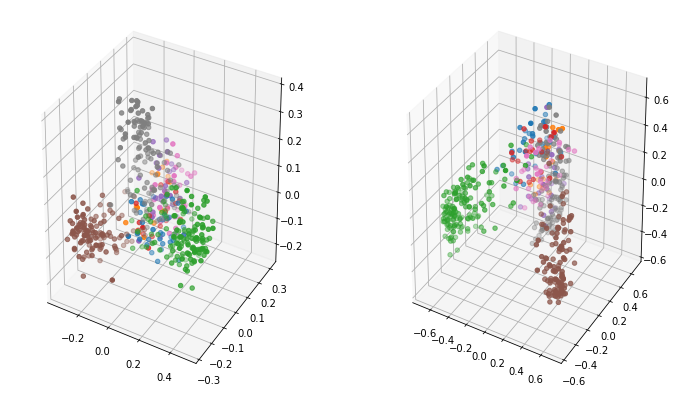

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
embs_facenet_norm = embs_facenet/(np.linalg.norm(embs_facenet, axis=1)).reshape(-1,1)
facenet_pca = pca.fit_transform(embs_facenet_norm)

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(1,2,1, projection='3d')
for label in np.unique(labels):
    cluster = facenet_pca[np.where(labels == label)]
    ax1.scatter3D(cluster[:,0], cluster[:,1], cluster[:,2])

pca = PCA(n_components=3)
embs_arcface_norm = embs_arcface / (np.linalg.norm(embs_arcface, axis=1)).reshape(-1,1)
arcface_pca = pca.fit_transform(embs_arcface_norm)

ax2 = fig.add_subplot(1,2,2, projection='3d')
for label in np.unique(labels):
    cluster = arcface_pca[np.where(labels == label)]
    ax2.scatter3D(cluster[:,0], cluster[:,1], cluster[:,2])
    
plt.show()